# Get sorted spikes and bouts and make rasters/gpfa

For every run in the session:
 - Load the recordings
 - Get the sync events for the nidq, ap, lf sync channels -> to npy for further synching 
 - Sort spikes
 - Get the bouts/mots and align them to the ap_0 time scale
 - make and view some 'bout rasters'
 

Assumes that preprocessing has occured:
- sglx_preprocess:
    - extraction of microphone streams
    - bout detections
- curate_bouts-bird-plotly-ephys:
    - manual curation of detected bouts
- sort_raster_bout:
    - syncrhonization of nidaq/ap time events
    - spike sorting
    - labeling of sorted units for their corresponding nucleus
    - inspection of rasters
    
This notebook should not depend on the raw_data

In [1]:
%matplotlib inline

import os
import glob
import logging
import pickle
import socket
import tempfile
import multiprocessing
import json

import numpy as np
import pandas as pd

from scipy.io import wavfile
from scipy import signal
from matplotlib import pyplot as plt

from importlib import reload
from multiprocessing import Process


logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

N_JOBS_MAX = multiprocessing.cpu_count()

logger.info('Running on {}'.format(socket.gethostname()))

2022-11-19 15:04:14,427 root         INFO     Running on pakhi.ucsd.edu


In [2]:
from ceciestunepipe.file import bcistructure as et

from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util import sglxsync as sy
from ceciestunepipe.util import stimutil as su
from ceciestunepipe.util import plotutil as pu
from ceciestunepipe.util import wavutil as wu
from ceciestunepipe.util import fileutil as fu
from ceciestunepipe.util.spike import kilosort as ks
from ceciestunepipe.util.sound import spectral as sp
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import readSGLX as rsgl
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import spikeglxrecordingextractor as sglex

from ceciestunepipe.pipeline import searchbout as sb

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
logger.info('all modules loaded')

2022-11-19 15:04:16,211 root         INFO     all modules loaded


In [3]:
pd.__version__

'1.4.2'

### Session parameters

In [4]:
reload(et)

bird = 's_b1555_22'
all_bird_sess = et.list_sessions(bird)
#all_bird_sess

In [5]:
reload(et)

sess_par = {'bird': bird,
           'sess': '2022-10-11',
           'probe': 'probe_0',
           'sort': 'sort_0',
           'trial_tag_chan': 0, # what whas the tag channel in the stimulus wave (this should come from meta et. al)
            'on_signal': 1, # whether singnal on is hi or lo
            'ref_stream': 'ap_0', #what to syncrhonize everything to
           'stim_sess': None, # if there was a stimulus epoch, where the stimuli were coming from
           'mic_chan': 0, # where the microphone is in the wav_mic.npy array
           'pre_chan': 0} # where the pressure is in the wav_adc.npy array




In [6]:
exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])
sess_epochs = et.list_sgl_epochs(sess_par)
sess_epochs

2022-11-19 15:04:19,081 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1555_22', 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-10-11', 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-10-11/sglx', 'kwik': '/scratch/earneodo/s_b1555_22/sglx/kwik/2022-10-11', 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-10-11/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-10-11/sglx', 'tmp': '/scratch/earneodo/tmp', 'msort': '/scratch/earneodo/s_b1555_22/sglx/msort/2022-10-11', 'ksort': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-10-11/sort_0', 'sort': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-10-11/sglx/sort_0'}, 'files': {'par': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-10-11/sort_0/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-10-11/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-10-11/sglx/rig.json', 'kwd': '/scratch/

['1549_stim_g0', '1817_g0', '1817_g1']

In [8]:
### pick a session, epoch
reload(et)
reload(sglu)
epoch = sess_epochs[0] # g2 is the shortest
sess_par['epoch'] = epoch

exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])

derived_folder = exp_struct['folders']['derived']

In [9]:
exp_struct

{'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/1549_stim_g0',
  'raw': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-10-11/1549_stim_g0',
  'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-10-11/sglx/1549_stim_g0',
  'kwik': '/scratch/earneodo/s_b1555_22/sglx/kwik/2022-10-11/1549_stim_g0',
  'processed': '/mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-10-11/sglx/1549_stim_g0',
  'derived': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-10-11/sglx/1549_stim_g0',
  'tmp': '/scratch/earneodo/tmp/1549_stim_g0',
  'msort': '/scratch/earneodo/s_b1555_22/sglx/msort/2022-10-11/1549_stim_g0',
  'ksort': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-10-11/1549_stim_g0/sort_0',
  'sort': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-10-11/sglx/1549_stim_g0/sort_0'},
 'files': {'par': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-10-11/1549_stim_g0/params.json',
  'set': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-10-11/sglx/settings.isf',
  'r

In [10]:
derived_folder

'/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-10-11/sglx/1549_stim_g0'

In [12]:
!ls $derived_folder

ap_0_sync_dict.pkl     wav_adc.wav
ap_0_sync_evt.npy      wav_mic.npy
ap_0_t0.npy	       wav_mic.wav
lf_0_sync_dict.pkl     wav_stim.npy
lf_0_sync_evt.npy      wav_stim_sync_sine_ttl_evt.npy
lf_0_t0.npy	       wav_stim_sync_sine_ttl.npy
lf_0-tp.npy	       wav_stim_sync_sine_ttl_t.npy
nidq_sync_dict.pkl     wav_stim.wav
nidq_sync_evt.npy      wav_sync_dict.pkl
nidq_t0.npy	       wav_sync_evt.npy
nidq-tp.npy	       wav_sync.npy
preprocess_par.pickle  wav_sync.wav
sort_0		       wav_t0.npy
stim_dict_ap0.pkl      wav-tp.npy
stim_pd_ap0.pkl        wav_ttl_evt.npy
wav_adc.npy


### load epoch files

In [13]:
### get the spikes df, clu df, bouts and syncrhonization files

## the sort
sort_folder = os.path.join(exp_struct['folders']['derived'], sess_par['sort'])

logger.info('Loading sort files from ' + sort_folder)

clu_df_path = os.path.join(sort_folder, 'clu_df.pickle')
clu_df = pd.read_pickle(clu_df_path)

spk_df_path = os.path.join(sort_folder, 'spk_df.pickle')
spk_df = pd.read_pickle(spk_df_path)


## the bout/stim
bout_dict_path = os.path.join(exp_struct['folders']['derived'], 'stim_dict_ap0.pkl')
bout_df_path = os.path.join(exp_struct['folders']['derived'], 'stim_pd_ap0.pkl')

logger.info('loading synced bout and dict and pandas dataframe from {}, {}'.format(bout_dict_path, bout_df_path))
with open(bout_dict_path, 'rb') as handle:
    bout_dict = pickle.load(handle)
bout_df = pd.read_pickle(bout_df_path)


#load the mic, pressure if any
mic_path = os.path.join(exp_struct['folders']['derived'], 'wav_mic.wav')
adc_path = os.path.join(exp_struct['folders']['derived'], 'wav_adc.wav')

s_f_wav, mic_stream = wu.read_wav_chan(exp_struct['files']['wav_mic'], sess_par['mic_chan'])
s_f_wav, pre_stream = wu.read_wav_chan(adc_path, sess_par['pre_chan'])

ap_sf = bout_dict['s_f_ap_0']

2022-11-19 15:04:54,647 root         INFO     Loading sort files from /mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-10-11/sglx/1549_stim_g0/sort_0
2022-11-19 15:04:55,448 root         INFO     loading synced bout and dict and pandas dataframe from /mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-10-11/sglx/1549_stim_g0/stim_dict_ap0.pkl, /mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-10-11/sglx/1549_stim_g0/stim_pd_ap0.pkl


In [14]:
bout_dict_path

'/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-10-11/sglx/1549_stim_g0/stim_dict_ap0.pkl'

In [15]:
# #load the mic, pressure if any
# mic_path = os.path.join(exp_struct['folders']['derived'], 'wav_mic.npy')
# adc_path = os.path.join(exp_struct['folders']['derived'], 'wav_adc.npy')

# mic_stream = np.memmap(adc_path)

In [16]:
bout_df.keys()

Index(['start', 'end', 'tag_freq_int', 'tag_freq', 'stim_name', 'start_ms',
       'len_ms', 'start_ms_ap_0', 'start_sample_ap_0', 'start_sample_naive',
       'start_sample_nidq'],
      dtype='object')

In [17]:
bout_dict.keys()

dict_keys(['s_f', 's_f_nidq', 's_f_ap_0', 'start_ms', 'len_ms', 'start_sample_naive', 'start_sample_nidq', 'start_sample_wav', 'start_ms_ap_0', 'start_sample_ap_0', 'end_sample_ap_0', 'tag_freq', 'stim_name'])

### Visualize a bout together with the neural traces

In [18]:
plt.rcParams['lines.linewidth'] = 0.1

In [19]:
axes_pars = {'axes.labelpad': 5,
             'axes.titlepad': 5,
             'axes.titlesize': 'small',
             'axes.grid': False,
             'axes.xmargin': 0,
             'axes.ymargin': 0}

plt.rcParams.update(axes_pars)

### collect all the bouts

In [20]:
bout_df.keys()

Index(['start', 'end', 'tag_freq_int', 'tag_freq', 'stim_name', 'start_ms',
       'len_ms', 'start_ms_ap_0', 'start_sample_ap_0', 'start_sample_naive',
       'start_sample_nidq'],
      dtype='object')

In [21]:
bout_dict.keys()

dict_keys(['s_f', 's_f_nidq', 's_f_ap_0', 'start_ms', 'len_ms', 'start_sample_naive', 'start_sample_nidq', 'start_sample_wav', 'start_ms_ap_0', 'start_sample_ap_0', 'end_sample_ap_0', 'tag_freq', 'stim_name'])

In [22]:
def collect_bouts_df(bout_df, bout_dict, spk_df, clu_list, mic_stream, pre_stream, t_pre=-2, t_post=2):
    # get t_pre, t_post in samples for wav, ap
    # tet start_end samples for each
    # collect the spikes
    # collect the streams
    bout_dict['t_pre'] = t_pre
    bout_dict['t_post'] = t_post
    
    sf_ap = bout_dict['s_f_ap_0']
    sf = bout_dict['s_f']
    
    pre_ap, post_ap = [int(x * sf_ap) for x in [t_pre, t_post]]
    pre_wav, post_wav = [int(x * sf) for x in [t_pre, t_post]]
    
    bout_df['len_sample_ap_0'] = (bout_df['len_ms'] * sf_ap * 0.001).astype(int)
    bout_df['end_sample_ap_0'] = bout_df['start_sample_ap_0'] + bout_df['len_sample_ap_0']

    bout_df['spk_arr'] = bout_df.apply(lambda x: ks.get_window_spikes(spk_df, clu_list, 
                                                                      x['start_sample_ap_0'] + pre_ap, 
                                                                      x['end_sample_ap_0'] + post_ap), 
                                       axis=1)

    bout_df['mic_arr'] = bout_df.apply(lambda x: mic_stream[x['start_sample']+pre_wav: x['end_sample']+post_wav], 
                                       axis=1)
    bout_df['pre_arr'] = bout_df.apply(lambda x: pre_stream[x['start_sample']+pre_wav: x['end_sample']+post_wav], 
                                       axis=1)
    
    # while we are at it, compute the spectrograms (ms scale)
    bout_df['sxx'] = bout_df['mic_arr'].apply(lambda x: sp.ms_spectrogram(x.flatten(), sf))
    
    # split the spectrogram to be able to work with hdf5 save/load.
    # don't want to be saving tuples, rather arrays
    bout_df[['f_xx', 't_xx', 's_xx']] = pd.DataFrame(bout_df['sxx'].tolist(), index=bout_df.index)
    
    bout_df['clu_id_arr'] = [clu_list for x in bout_df.index]
    
    return bout_df

In [28]:
bin_ms = 15
bin_sample_ap = int(bin_ms*0.001*bout_dict['s_f_ap_0'])
bout_df['spk_bin_arr'] = bout_df['spk_arr'].apply(lambda z: np.nan_to_num(pu.coarse(z, bin_sample_ap)))

/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:66: RuntimeWarning: Mean of empty slice
  coarse_x = np.nanmean(exploded_x, axis=-1)


In [23]:
### one spk_arr
# mot_idx = 0

# start_ap = bout_df.loc[mot_idx, 'start_sample_ap_0']
# end_ap = bout_df.loc[mot_idx, 'end_sample_ap_0']

# spk_arr = ks.get_window_spikes(spk_df, clu_list, start_ap - 60000 , end_ap+60000)

In [24]:
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['ncm'])), 
                                'cluster_id'])

t_pre = - 5
t_post = 5

bout_df['start_sample'] = bout_df['start']
bout_df['end_sample'] = bout_df['end']
bout_df = collect_bouts_df(bout_df, bout_dict, spk_df, clu_list, mic_stream, pre_stream, 
                           t_pre=t_pre, t_post=t_post)

/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/spike/kilosort.py:112: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


##### sanity check, plot one of the bout-rasters

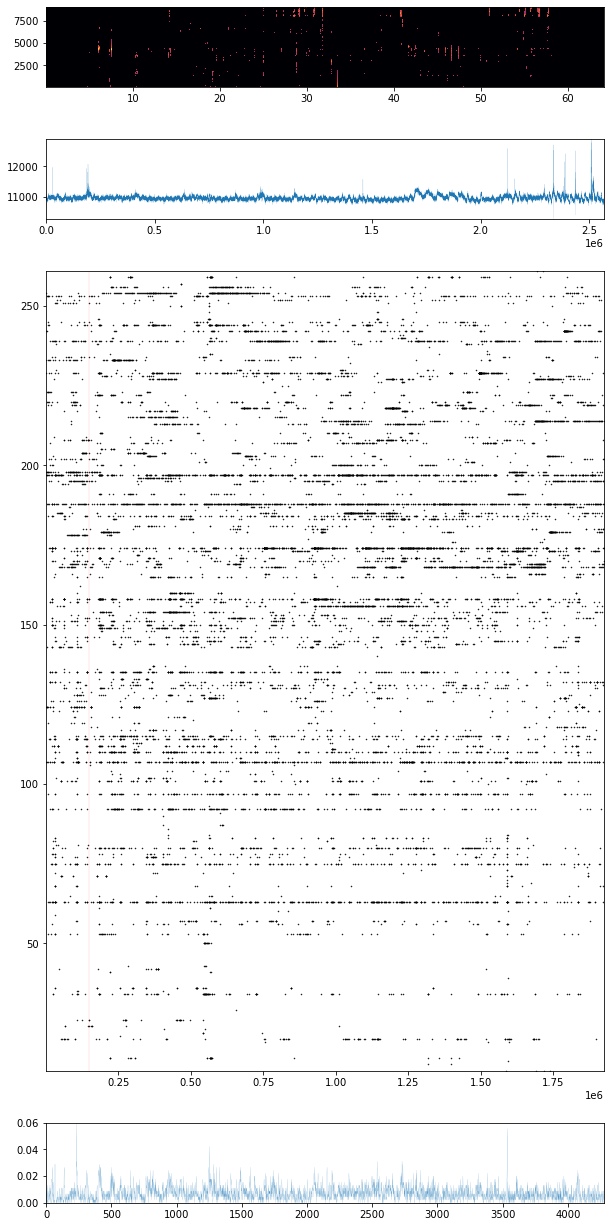

In [30]:
def plot_bout(bout_series, bout_dict):
    # get the raster, the spectrogram and the pressure
    
    t_pre = bout_dict['t_pre']
    s_f_ap = bout_dict['s_f_ap_0']
    s_f = bout_dict['s_f']
    
    mic_arr = bout_series['mic_arr']
    pre_arr = bout_series['pre_arr']
    spk_arr = bout_series['spk_arr']
    # plot
    
    fig, ax = plt.subplots(nrows=4, gridspec_kw={'height_ratios': [1, 1, 10, 1]}, figsize=(10, 22))

    f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), s_f)

    #ax[0].plot(mic_arr.flatten())
    ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
    ax[1].plot(pre_arr.flatten());
    pu.plot_as_raster(spk_arr, t_0=int(-t_pre*s_f_ap), ax=ax[2])
    
    ax[3].plot(np.nansum(bout_series['spk_bin_arr'], axis=0))
    
plot_bout(bout_df.iloc[8], bout_dict)

### get all the gpfa

In [31]:
import neo
import quantities as pq
from elephant.gpfa import GPFA
import viziphant as vp

Elephant wants nested lists of SpikeTrain objects.
[n_trials, n_spiketrains, n_spikes] (each spike is a time where a spike occurred)

The strategy is to do all the spiketrains, do the fit, then project each array and store that in the pandas dataframe bout_df

In [32]:
def spike_trains_from_spk_arr(spk_arr, s_f):
    # get the time of the spikes
    # make a neo SpikeTrain for each cluster
    t_stop = spk_arr.shape[1]/s_f
    spk_train_list = [neo.SpikeTrain(times=np.where(x==1)[0]/s_f, units='sec', t_stop=t_stop) for x in spk_arr]
    
    return spk_train_list

In [33]:
bout_df['spk_train'] = bout_df['spk_arr'].apply(lambda x: spike_trains_from_spk_arr(x, bout_dict['s_f_ap_0']))

In [34]:
all_spk_train_list = list(bout_df['spk_train'])

In [35]:
# specify fitting parameters
bin_size = 15 * pq.ms
latent_dimensionality = 6

gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

In [36]:
## fit and project
all_spk_train_list = list(bout_df['spk_train'])
all_fit_list = gpfa_2dim.fit_transform(list(bout_df['spk_train']))
bout_df['spk_gpf'] = all_fit_list

print(gpfa_2dim.params_estimated.keys())

/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 13 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site

Initializing parameters using factor analysis...

Fitting GPFA model...


/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 13 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/mnt/cube/earneodo/envs/pakhi/ceciestunepipe/lib/python3.8/site

dict_keys(['covType', 'gamma', 'eps', 'd', 'C', 'R', 'notes', 'Corth'])


In [37]:
### project 
#all_fit_list = gpfa_2dim.transform(all_spk_train_list)

In [38]:
#### plot some

In [44]:
### a better spectrogram
def kozlov_averaging(spec, n_rows=2, n_cols=3):
    '''
    Average rows and columns of spectrogram according to Kozlov & Gentner 2016 
    In Andrei's paper he averaged twice along rows(frequency bins) and three times
    across columns (time bins).
    n_rows specifies how many times to average rows pairwise, and n_cols specifies how many times
    to average columsn pairwise.
    '''
    spec_c = np.copy(spec)

    for idx in range(n_rows):
        spec_c = avg_pairwise(spec_c, axis=0)

    for idx in range(n_cols):
        spec_c = avg_pairwise(spec_c, axis=1)

    return spec_c

def ms_spectrogram(x, s_f, n_window=512, step_ms=1, f_min=0, f_max=20000, 
                     ref_db=20, min_db=-30, avg_func=None):
    
    ### spectrogram
    f, t, sxx = sp.ms_spectrogram(x, s_f, n_window=n_window, step_ms=step_ms, 
                                  f_min=f_min, f_max=f_max, cut_off=0)
    
    spec = 10*np.log10(np.maximum(1e-5, sxx[1:, :])) - ref_db
    f = f[1:]
    
    # average, if specified
    if avg_func is not None:
        spec = avg_func(spec)

    # normalize
    spec = np.clip((spec - min_db) / (-1.0*min_db), 0, 1)
    
    spec[spec==np.nan] = 1
    return f, t, spec

bout_df['sxx'] = bout_df['mic_arr'].apply(lambda x: sp.ms_spectrogram(x.flatten(), bout_dict['s_f']))

In [45]:
#### get the PC of the spectrogram.

## cat all spectrogram to make a fit
## project each pc

from sklearn.decomposition import PCA

pca = PCA(n_components=3, svd_solver='full')

all_x = np.hstack(bout_df['sxx'].apply(lambda x: x[2]))
all_x[all_x==np.nan] = 1 ### better do a zscore

# fit all
pca.fit(np.log(all_x.T))

# project all
bout_df['sxx_pc'] = bout_df['sxx'].apply(lambda x: pca.transform(np.log(x[2].T)))

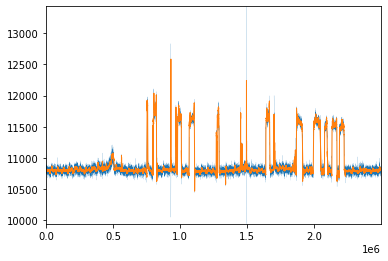

In [46]:
###filter the presure
import scipy
b, a = scipy.signal.butter(4, 1000, 'lp', fs=bout_dict['s_f'], output='ba')

bout_df['pre_filt'] = bout_df['pre_arr'].apply(lambda x: signal.filtfilt(b, a, x))

plt.plot(bout_df.iloc[55]['pre_arr'])
plt.plot(bout_df.iloc[55]['pre_filt'], lw=1)

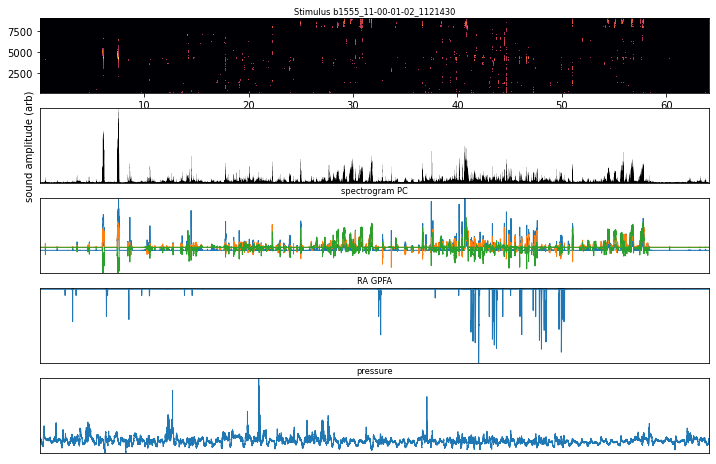

In [54]:
### se them together all for a bout now
def plot_bout_projections(bout_series):
    sxx_pc = bout_series['sxx_pc']
    gpf = bout_series['spk_gpf']
    pre_arr = bout_series['pre_filt']
    mic_arr = bout_series['mic_arr']
    
    f, t, sxx = bout_series['sxx']
    
    fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(12, 8));

    ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
    ax[0].set_title('Stimulus {}'.format(bout_series['stim_name']))
    
    ax[1].plot((np.abs(mic_arr)), 'k');
    ax[1].set_ylabel('sound amplitude (arb)')

    ax[2].set_title('spectrogram PC')
    ax[2].plot(sxx_pc, lw=1);

    ax[3].set_title('RA GPFA');
    ax[3].plot(gpf[:1].T, lw=1);

    ax[4].set_title('pressure');
    ax[4].plot(pre_arr, lw=1);
    
    for ax_i in ax[1:]:
        ax_i.set_xticks([])
        ax_i.set_yticks([])
    
    
    return ax


plot_bout_projections(bout_df.iloc[10])
print()

In [48]:
bout_df.iloc[38]['stim_name']

'b1251_13-00-01-01_44149'

In [46]:
%matplotlib notebook

In [47]:



#bout_df.to_hdf(bout_df_path, 'gpfa')

In [ ]:
### bring it dask because shit got big

In [198]:
h5py.run_tests()

Tests require pytest, pytest not installed


1

In [229]:
bout_df['p_step'].values.shape

(90,)

In [223]:
bout_df['s_xx'].values[2].shape

(114, 53253)

In [247]:
bout_df.loc[0]

start_ms                                                        5768678
end_ms                                                          5830888
start_sample                                                  230747120
end_sample                                                    233235520
p_step                [10.723472734493622, 13.967752222358655, 19.04...
rms_p                                                         40.838037
peak_p                                                        361.99498
bout_check                                                         True
file                  /mnt/sphere/speech_bci/derived_data/s_b1555_22...
len_ms                                                            62210
syl_in                [[5768678, 5768773], [5768798, 5769313], [5769...
n_syl                                                               130
peaks_p               [3, 11, 31, 39, 48, 57, 68, 75, 86, 93, 108, 1...
n_peaks                                                         

In [56]:
bout_df.keys()

Index(['start', 'end', 'tag_freq_int', 'tag_freq', 'stim_name', 'start_ms',
       'len_ms', 'start_ms_ap_0', 'start_sample_ap_0', 'start_sample_naive',
       'start_sample_nidq', 'start_sample', 'end_sample', 'len_sample_ap_0',
       'end_sample_ap_0', 'spk_arr', 'mic_arr', 'pre_arr', 'sxx', 'f_xx',
       't_xx', 's_xx', 'clu_id_arr', 'spk_bin_arr', 'spk_train', 'spk_gpf',
       'sxx_pc', 'pre_filt'],
      dtype='object')

In [55]:
bout_dict.keys()

dict_keys(['s_f', 's_f_nidq', 's_f_ap_0', 'start_ms', 'len_ms', 'start_sample_naive', 'start_sample_nidq', 'start_sample_wav', 'start_ms_ap_0', 'start_sample_ap_0', 'end_sample_ap_0', 'tag_freq', 'stim_name', 't_pre', 't_post'])

In [ ]:
### Save everything in an h5 file

### Save everything in an h5 file

In [72]:
bout_df['end_ms'] = bout_df['start_ms'] + bout_df['len_ms'] 
bout_df['bout_check'] = None
bout_df['confusing'] = None
bout_df['syl_in'] = [np.empty(0) for i in bout_df.index]

In [77]:
bout_df['file'] = exp_struct['files']['wav_mic']

In [64]:
import h5py
from ceciestunepipe.util import h5util as h5u

In [65]:
reload(h5u)

<module 'ceciestunepipe.util.h5util' from '/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/h5util.py'>

{'attr_keys': ['start_ms',
  'end_ms',
  'len_ms',
  'start_sample',
  'end_sample',
  'start_ms_ap_0',
  'start_sample_ap_0',
  'start_sample_naive',
  'len_sample_ap_0',
  'end_sample_ap_0',
  'bout_check',
  'confusing',
  'file'],
 'dset_keys': ['mic_arr',
  'pre_arr',
  'pre_filt',
  'syl_in',
  'f_xx',
  't_xx',
  's_xx',
  'sxx_pc',
  'spk_arr',
  'spk_gpf'],
 'dict_keys': ['s_f', 's_f_nidq', 's_f_ap_0', 't_pre', 't_post']}

In [51]:
### save these bouts as an hdf5 file
bout_df_path = os.path.join(exp_struct['folders']['processed'], 'bout_df_gpfa.h5')
fu.makedirs(exp_struct['folders']['processed'])

In [ ]:
h5u.bout_default_keys

In [73]:
attr_keys = h5u.bout_default_keys['attr_keys'] + ['stim_name']

In [78]:
logger.info('Saving the gpfa, pca results onto an hdf5 file {}'.format(bout_df_path))
h5u.bouts_to_h5(bout_df, bout_dict, bout_df_path)
logger.info('done')

2022-11-22 16:45:29,884 root         INFO     Saving the gpfa, pca results onto an hdf5 file /mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-10-11/sglx/1549_stim_g0/bout_df_gpfa.h5
2022-11-22 16:54:48,680 root         INFO     done
